In [13]:
%matplotlib notebook
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [14]:
def func(x):
    return x[0]**2 + 2*x[1]**2 + (math.e)**(x[0] + x[1])

def funcP(x):
    return 2.8*x[1]**2 + 1.9*x[0] + 2.7*x[0]**2 + 1.6 - 1.9*x[1]

In [15]:
class NM:
    
    def __init__(self, func, n = 2, m = 0.5, b = 0.5, y = 2, eps = 0.0001, initP = (1, 1)):
        
        self.n = n          # Размерность
        self.m = m          # Длинна ребра симплекса
        self.b = b          # Коэффициент сжатия
        self.y = y          # Коэффициент растяжения
        self.eps = eps      # Точность поиска
        self.func = func    # Оптимизируемая функция
        self.counter = 0    # Счетчик итераций
        
        # Симплекс
        self.base = np.full_like(np.empty((n+1, n+1)), list(initP) + [0])
        
        # Приращения
        d1 = ((math.sqrt(n + 1) - 1)/(n*math.sqrt(2)))*m
        d2 = ((math.sqrt(n + 1) + n - 1)/(n*math.sqrt(2)))*m
        
        # Вычисление координат вершин симплекса
        for i in range(1, n+1):
            for j in range(n):
                self.base[i,j] += d1 if i == j+1 else d2
        
        # Вычисление значений функции в вершинах симплекса
        self.base[:,-1] = [self.func(p) for p in self.base[:,:-1]]
        
        self.baseHist = [*self.base.copy()]        # Таблица точек, составлявших симплекс
        self.baseHistSS = [self.base.copy(),]      # Состояния симплекса
        mi = np.argmin(self.base[:,-1])
        self.minPHist = [self.base[mi,:-1].copy()] # Найденные точки минимумов
        self.minFHist = [self.base[mi,-1].copy()]  # Значения функции в точке минимумов
        
            
    def execute(self):
        
        while True:
            
            needComp = False    # Необходимость сжатия
            
            # Номер вершины с наибольшим значением целевой функции
            h = np.argmax(self.base[:,-1])
            sortedF = np.sort(self.base[:,-1])
            fh = sortedF[-1]    # Наибольшее значение функции
            fg = sortedF[-2]    # 2-ое наибольшее значение функции
            fl = sortedF[0]     # Наименьшее значение функции
            
            # Вычисление координат отраженной точки и значения функции в ней
            xc = (1/self.n)*np.sum(np.delete(self.base[:,:-1], h, axis=0), axis=0)
            xr = 2*xc - self.base[h,:-1]
            fr = self.func(xr)
            
            # Отраженная точка лучшая -> делаем растяжение
            if fr < fl:
                
                # Операция растяжения
                xe = (1 - self.y)*xc + self.y*xr
                fe = self.func(xe)
                
                # Проверка успешности операции растяжения
                if fe < fr:
                    
                    # Замена худшей точки симплекса раятянутой
                    self.base[h,:] = list(xe) + [fe]
                    self.baseHist.append(self.base[h,:].copy())
                    
                elif fe > fr:
                    
                    # Замена худшей точки симплекса отраженной
                    self.base[h,:] = list(xr) + [fr]
                    self.baseHist.append(self.base[h,:].copy())
            
            # Новая точка лучше двух наибольших 
            if fl < fr < fg:
                
                # Замена худшей точки симплекса отраженной
                self.base[h,:] = list(xr) + [fr]
                self.baseHist.append(self.base[h,:].copy())
            
            # Отраженная точка между двумя наибольшими -> необходимо сжатие
            if fg < fr < fh:
                
                # Замена худшей точки симплекса отраженной
                self.base[h,:] = list(xr) + [fr]
                
                needComp = True    # Необходимо сжатие
            
            # Отраженная точка худшая -> необходимо сжатие
            if fh < fr:
                
                needComp = True    # Необходимо сжатие
                
            # Если необходимо сжатие
            if needComp == True:
                
                # Операция сжатия
                xs = (1 - self.b)*xc + self.b*self.base[h,:-1]
                fs = self.func(xs)
                
                # Проверка успешности операции сжатия
                if fs < fh:
                    
                    # Замена худшей точки симплекса сжатой
                    self.base[h,:] = list(xs) + [fs]
                    self.baseHist.append(self.base[h,:].copy())
                    
                elif fs > fh:
                    
                    # Операция редукции
                    r = np.argmin(self.base[:,-1])
                    minP = self.base[r,:-1]
                    scale = lambda x: minP + self.m*(x-minP)
                    self.base[:,:-1] = scale(self.base[:,:-1])
                    self.base[:,-1] = [self.func(p) for p in self.base[:,:-1]]
                    
                    # Добавление новых точек в таблицу
                    self.baseHist.extend(np.delete(self.base, h, axis=0))
            
            # Сохранение текущего состояния симплекса и увелечение счетчика
            self.baseHistSS.append(self.base.copy())
            mi = np.argmin(self.base[:,-1])
            self.minPHist.append(self.base[mi,:-1].copy())
            self.minFHist.append(self.base[mi,-1].copy())
            self.counter += 1
            
            # Вычисление значения функции в центре тяжести симплекса
            cgF = self.func((1/(self.n+1))*np.sum(self.base[:,:-1], axis=0))
            
            # Проверка условия окончания процесса вычислений
            if math.sqrt((1/(self.n+1))*np.sum((self.base[:,-1] - cgF)**2)) < eps:
                break
                

In [16]:
fun = func
n = 2
m = 0.5
b = 0.5
y = 2
eps = 0.0001
initP = (-4, 4)

nm = NM(fun, n, m, b, y, eps, initP)
nm.execute()

In [17]:
resSS = [list(map(lambda x: list(x)[:-1], ss)) for ss in nm.baseHistSS]
minP = nm.minPHist
minF = nm.minFHist

print(f'\n\nНайденная точка минимума: {tuple(minP[-1])}\n')
print(f'Найденный минимум: {minF[-1]}\n')
print(f'Количество итераций: {nm.counter}\n\n')
print(f'Таблица точек симплекса:\n')
print('{0:>10}  {1:>10}  {2:>15}\n'.format('x1', 'x2', 'func(x1, x2)'))
for p in nm.baseHist:
    print('{0:10.5f}  {1:10.5f}  {2:15.5f}'.format(p[0], p[1], p[2]))



Найденная точка минимума: (-0.31747851053172116, -0.15562652143515474)

Найденный минимум: 0.772296459035092

Количество итераций: 22


Таблица точек симплекса:

        x1          x2     func(x1, x2)

  -4.00000     4.00000         49.00000
  -3.87059     4.48296         57.02019
  -3.51704     4.12941         48.31840
  -3.53437     3.22819         34.07046
  -2.57712     3.03640         26.66388
  -2.13316     1.13806          7.51043
   0.00333    -0.19469          0.90165
  -0.30882    -0.81067          1.73620
  -1.14296     0.31769          1.94632
  -0.64785    -0.09250          0.91377
  -0.31554    -0.47713          1.00751
  -0.31890    -0.31036          0.82733
  -0.40282    -0.17251          0.78430
  -0.17877    -0.21807          0.79951
  -0.26268    -0.08021          0.79158
  -0.25576    -0.17221          0.77656
  -0.29599    -0.12629          0.77506
  -0.33935    -0.16088          0.77331
  -0.28671    -0.15790          0.77314
  -0.30451    -0.14284          0.7

<IPython.core.display.Javascript object>


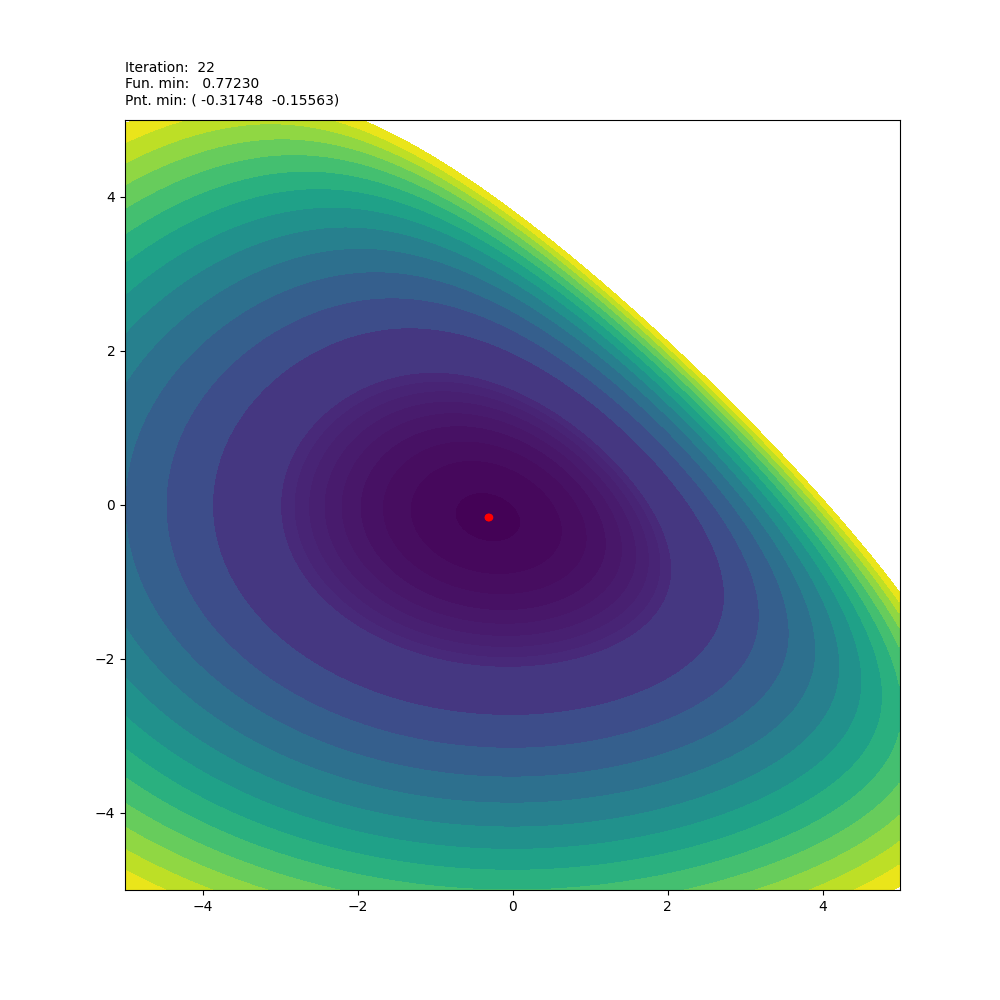

In [19]:
delta = 0.01
x = np.arange(-5, 5, delta)
y = np.arange(-5, 5, delta)
X, Y = np.meshgrid(x, y)
Z = func((X, Y))

figA = plt.figure(figsize=(10, 10))
axA = figA.add_subplot()

plt.xlim(-5, 5)
plt.ylim(-5, 5)

axA.contourf(X, Y, Z, np.concatenate((np.arange(0, 10, 1), np.arange(15, 80, 5))))


scat = axA.scatter([], [], s=20, c='red')
temp = axA.text(-5, 5.2, '')
    
def animate(i):
    temp.set_text('Iteration: {0:3d}\nFun. min: {1:9.5f}\nPnt. min: ({2:9.5f} {3:9.5f})'.format(i, minF[i], minP[i][0], minP[i][1]))
    scat.set_offsets(resSS[i])
    
anim1 = FuncAnimation(figA, animate, frames=len(resSS), interval=1000, repeat=False)